In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV


from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import classification_report, confusion_matrix


In [2]:
df = pd.read_pickle("../data/reviews_vector_ngrams.pkl")

In [3]:
df[:10].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Columns: 504 entries, overall to your
dtypes: float64(501), int64(2), object(1)
memory usage: 39.5+ KB


In [4]:
[df.columns[:3],df.columns[4:]]

[Index(['overall', 'reviewText', 'length'], dtype='object'),
 Index(['10', '100', 'abl', 'absolut', 'access', 'actual', 'ad', 'adapt', 'add',
        'advertis',
        ...
        'worri', 'worth', 'would', 'would buy', 'would recommend', 'wouldnt',
        'wrong', 'year', 'yet', 'your'],
       dtype='object', length=500)]

In [5]:
minority_count = df[df['binary'] == 0].shape[0]
# random sample of majority class
majority_sample = df[df['binary'] == 1].sample(n=minority_count, random_state=42)

# merge to make balanced dataset
balanced_df = pd.concat([df[df['binary'] == 0], majority_sample])

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [6]:
y_prime = balanced_df["binary"]

In [7]:
y_prime.value_counts()

binary
1    185626
0    185626
Name: count, dtype: int64

In [8]:
X=df[df.columns[4:]]
y=df["binary"]
X_prime = balanced_df[balanced_df.columns[4:]]


In [9]:
y.value_counts(), y_prime.value_counts()

(binary
 1    704818
 0    185626
 Name: count, dtype: int64,
 binary
 1    185626
 0    185626
 Name: count, dtype: int64)

Natural distribution vs downsampling the majority class

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [11]:
X_train_prime, X_test_prime, y_train_prime, y_test_prime = train_test_split(X_prime, y_prime, test_size=0.2, stratify=y_prime, random_state=42)

In [12]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)

In [13]:
scaler_prime = StandardScaler()
scaler_prime.fit(X_train_prime)
X_train_transformed_prime = scaler.transform(X_train_prime)
X_test_transformed_prime = scaler.transform(X_test_prime)

In [14]:
# # testing for C value
# penalties = [0.1, 1, 10, 100]

# cvs1=[]

# for c in penalties:
#     # change depth each time
#     estimators = [('normalise', StandardScaler()),
#                 ('model', LogisticRegression(C=c,penalty='l1', solver='liblinear',random_state=42))]
#     pipe = Pipeline(estimators,verbose=True)
#     # fitting
#     pipe.fit(X_train, y_train)
#     cvs =cross_val_score(pipe, X_train, y_train, cv=5).mean()
#     cvs1.append(cvs)
#     print(f"penalty: {c} Cross Validation accuracy: {cvs}")

In [15]:
# cvs1

In [16]:
# plt.figure(figsize=(10,8))
# plt.plot(cvs1)
# # 
# plt.show();

In [17]:


estimators = [('normalise', StandardScaler()), 
              ('model', LogisticRegression(C=1,penalty='l1', solver='liblinear',random_state=42))]
pipe_final = Pipeline(estimators,verbose=True)
pipe_final_prime = Pipeline(estimators,verbose=True)

In [18]:
pipe_final.fit(X_train, y_train)


[Pipeline] ......... (step 1 of 2) Processing normalise, total=   3.0s
[Pipeline] ............. (step 2 of 2) Processing model, total= 1.7min


Pipeline(steps=[('normalise', StandardScaler()),
                ('model',
                 LogisticRegression(C=1, penalty='l1', random_state=42,
                                    solver='liblinear'))],
         verbose=True)

In [19]:
pipe_final_prime.fit(X_train_prime, y_train_prime)


[Pipeline] ......... (step 1 of 2) Processing normalise, total=   0.9s
[Pipeline] ............. (step 2 of 2) Processing model, total=   8.8s


Pipeline(steps=[('normalise', StandardScaler()),
                ('model',
                 LogisticRegression(C=1, penalty='l1', random_state=42,
                                    solver='liblinear'))],
         verbose=True)

In [20]:
log_clas = pipe_final[-1]
log_clas_prime = pipe_final_prime[-1]



In [21]:
log_clas

LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear')

In [22]:
log_clas.score(X_train_transformed, y_train), log_clas.score(X_train_transformed_prime, y_train_prime)

(0.7275782439935145, 0.7949939562493056)

In [23]:
log_clas.score(X_test_transformed, y_test), log_clas.score(X_test_transformed_prime, y_test_prime)

(0.7272206593332547, 0.7959354082773296)

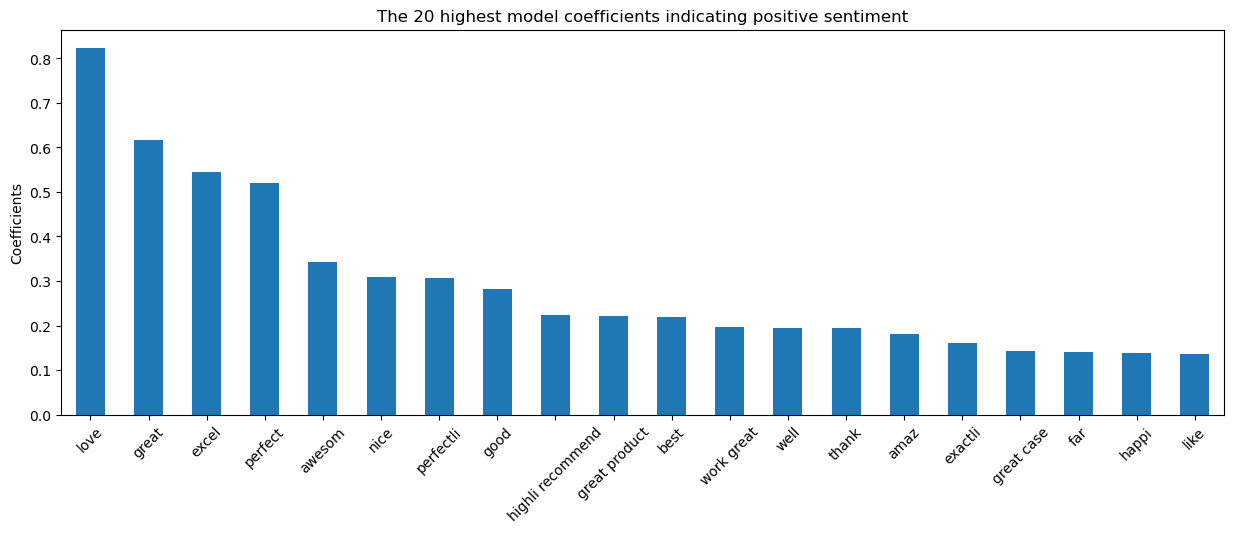

In [24]:
word_counts = pd.DataFrame(
    {"coefficients": log_clas.coef_[0]},
    index=X_train.columns
).sort_values("coefficients", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)

plt.title("The 20 highest model coefficients indicating positive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

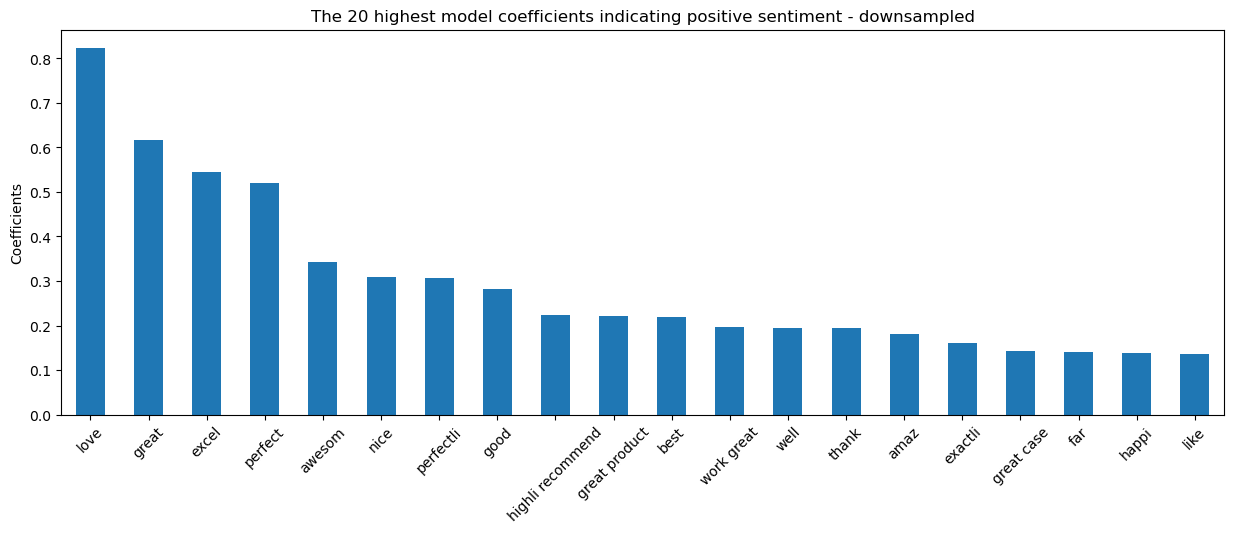

In [25]:
word_counts = pd.DataFrame(
    {"coefficients": log_clas_prime.coef_[0]},
    index=X_train_prime.columns
).sort_values("coefficients", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)

plt.title("The 20 highest model coefficients indicating positive sentiment - downsampled")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

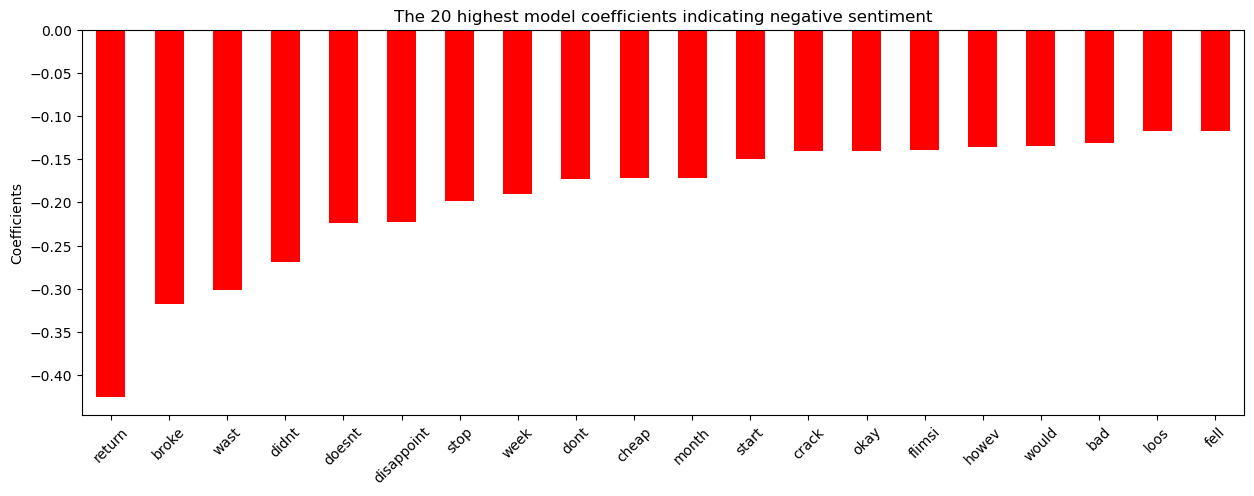

In [26]:
word_counts = pd.DataFrame(
    {"coefficients": log_clas.coef_[0]},
    index=X_train.columns
).sort_values("coefficients", ascending=True)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False, color='red')

plt.title("The 20 highest model coefficients indicating negative sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

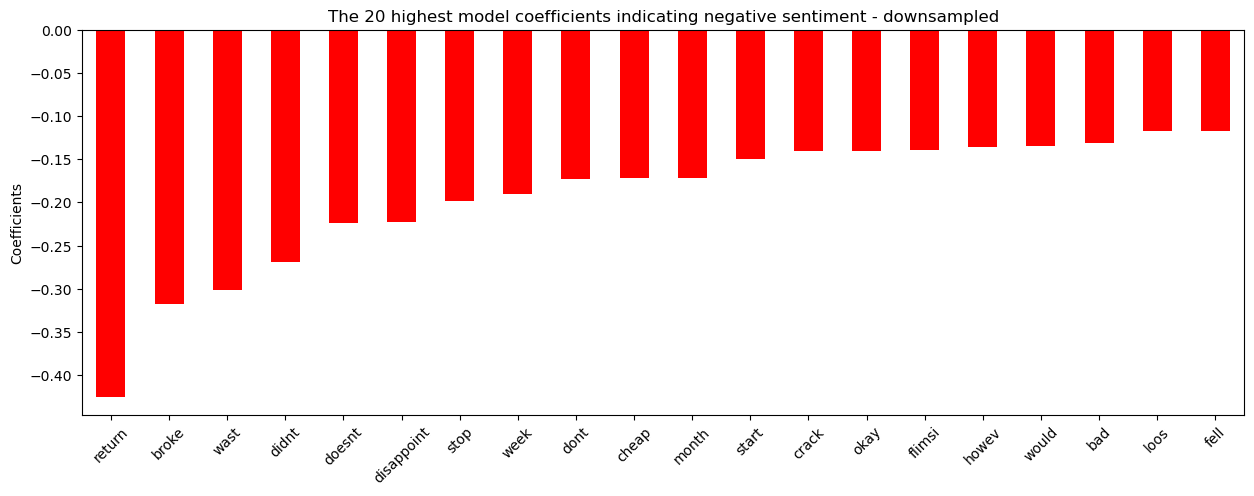

In [27]:
word_counts = pd.DataFrame(
    {"coefficients": log_clas_prime.coef_[0]},
    index=X_train_prime.columns
).sort_values("coefficients", ascending=True)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False, color='red')

plt.title("The 20 highest model coefficients indicating negative sentiment - downsampled")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

In [28]:
y_pred_baseline_test= log_clas.predict(X_test_transformed)

cm = confusion_matrix(y_test, y_pred_baseline_test, normalize="true")
cm_count = confusion_matrix(y_test, y_pred_baseline_test)

In [29]:
y_pred_baseline_test_prime= log_clas_prime.predict(X_test_transformed_prime)
cm_prime = confusion_matrix(y_test_prime, y_pred_baseline_test_prime, normalize="true")
cm_prime_count = confusion_matrix(y_test_prime, y_pred_baseline_test_prime)

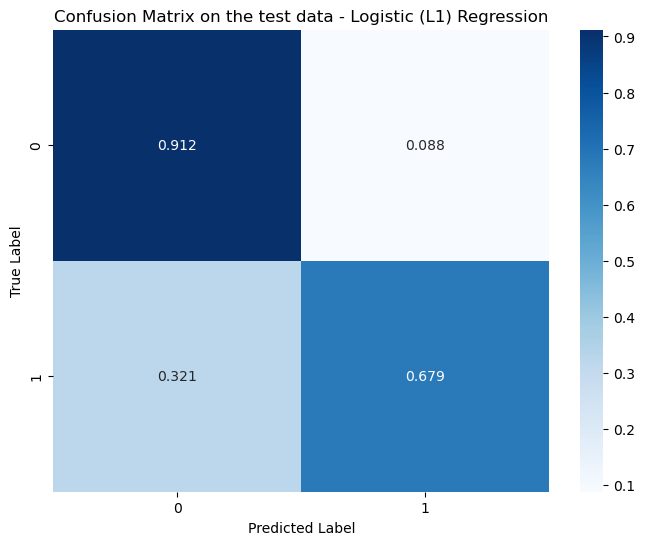

In [30]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".3f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on the test data - Logistic (L1) Regression")
plt.show()

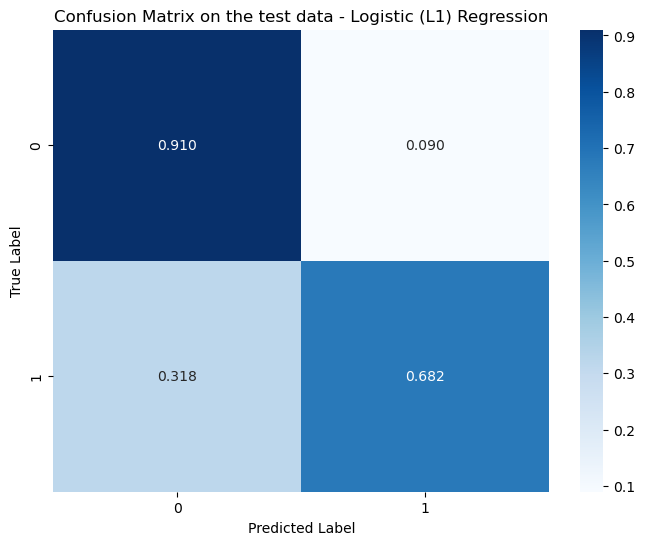

In [31]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_prime, annot=True, fmt=".3f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on the test data - Logistic (L1) Regression")
plt.show()

In [32]:
y_pred_baseline= log_clas.predict(scaler.transform(df[df.columns[4:]]))


In [33]:
incorrect_guesses = df["binary"] != y_pred_baseline
incorrect_v = pd.Series(y_pred_baseline)[incorrect_guesses]
pd.concat([pd.Series(incorrect_v),df[incorrect_guesses]], axis=1)


,0,overall,reviewText,length,binary,10,100,abl,absolut,access,...,worri,worth,would,would buy,would recommend,wouldnt,wrong,year,yet,your
1,0,5.0,When you don't want to spend a whole lot of ca...,102,1,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0
2,1,3.0,"so the case came on time, i love the design. I...",257,0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.20051,0.0
4,0,4.0,"I liked it because it was cute, but the studs ...",150,1,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.233344,0.0,0.346372,0.000000,0.0,0.0,0.00000,0.0
18,0,5.0,I have used this case for a couple weeks & so ...,132,1,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0
20,0,5.0,I chose this case because it is so beautiful. ...,171,1,0.0,0.0,0.289742,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890415,0,5.0,Didn't think I would like it because I'm use t...,132,1,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.199313,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0
890425,0,5.0,"Works great, this was a replacement for the or...",88,1,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0
890435,0,5.0,Charges my phone very quickly.,30,1,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0
890438,0,5.0,Wouldn't be able to live without it. Strong ma...,73,1,0.0,0.0,0.380245,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.404406,0.0,0.0,0.00000,0.0
